In [19]:
import sklearn.metrics as skm
import sys
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

ssl_features_train = np.load("./old_but_full_features/self_supervised_cifar100/features_train2.npy")
ssl_labels_train = np.load("./old_but_full_features/self_supervised_cifar100/labels_train2.npy")
ssl_features_test = np.load("./old_but_full_features/self_supervised_cifar100/features_test2.npy")
ssl_features_ood = np.load("./old_but_full_features/self_supervised_cifar100/features_ood2.npy")

#ssl_features_train = np.load("./ssl_2/features_train2.npy")
#ssl_labels_train = np.load("./ssl_2/labels_train2.npy")
#ssl_features_test = np.load("./ssl_2/features_test.npy")
#ssl_features_ood = np.load("./ssl_2/features_ood.npy")


cl_features_train = np.load("./supervised_contrastive_cifar10/features_train2.npy")
cl_labels_train = np.load("./supervised_contrastive_cifar10/labels_train2.npy")
cl_features_test = np.load("./supervised_contrastive_cifar10/features_test.npy")
cl_features_ood = np.load("./supervised_contrastive_cifar10/features_ood.npy")


sp_features_train = np.load("./old_but_full_features/supervised_cifar100/features_train2.npy")
sp_labels_train = np.load("./old_but_full_features/supervised_cifar100/labels_train2.npy")
sp_features_test = np.load("./old_but_full_features/supervised_cifar100/features_test2.npy")
sp_features_ood = np.load("./old_but_full_features/supervised_cifar100/features_ood2.npy")

ds_features_train = np.load("./distillation1/features_train2.npy")
ds_labels_train = np.load("./distillation1/labels_train2.npy")
ds_features_test = np.load("./distillation1/features_test.npy")
ds_features_ood = np.load("./distillation1/features_ood.npy")


In [20]:
# -- calculate SL and SSL score separately


import sklearn.metrics as skm
import sys
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

def get_roc_sklearn(xin, xood):
    labels = [0] * len(xin) + [1] * len(xood)
    data = np.concatenate((xin, xood))
    auroc = skm.roc_auc_score(labels, data)
    fpr,tpr,_ = roc_curve(labels, data)
    operation_idx = np.abs(tpr-0.95).argmin()
    fpr95 = fpr[operation_idx]
    return auroc, fpr95


def get_scores_multi_cluster(ftrain, ftest, food, ypred):
    print("using multiple clusters")
    xc = [ftrain[ypred == i] for i in np.unique(ypred)]
    

    din = [
        np.sum(
            (ftest - np.mean(x, axis=0, keepdims=True))
            * (
                np.linalg.pinv(np.cov(x.T, bias=True)).dot(
                    (ftest - np.mean(x, axis=0, keepdims=True)).T
                )
            ).T,
            axis=-1,
        )
        for x in xc
    ]
    dood = [
        np.sum(
            (food - np.mean(x, axis=0, keepdims=True))
            * (
                np.linalg.pinv(np.cov(x.T, bias=True)).dot(
                    (food - np.mean(x, axis=0, keepdims=True)).T
                )
            ).T,
            axis=-1,
        )
        for x in xc
    ]
#     print("din shape is looking like:", din)
    din_index = np.argmin(din, axis = 0)
    
    din = np.min(din, axis=0)
    
    dood_index = np.argmin(dood, axis = 0)
    dood = np.min(dood, axis=0)

    return din, dood, din_index, dood_index

def get_scores(ftrain, ftest, food, labelstrain, cluster):

    # standardize data
    print("ftrain size is:", ftrain.shape)
    ftrain /= np.linalg.norm(ftrain, axis=-1, keepdims=True) + 1e-10
    ftest /= np.linalg.norm(ftest, axis=-1, keepdims=True) + 1e-10
    food /= np.linalg.norm(food, axis=-1, keepdims=True) + 1e-10

    m, s = np.mean(ftrain, axis=0, keepdims=True), np.std(ftrain, axis=0, keepdims=True)

    ftrain = (ftrain - m) / (s + 1e-10)
    ftest = (ftest - m) / (s + 1e-10)
    food = (food - m) / (s + 1e-10)
    
    return get_scores_multi_cluster(ftrain, ftest, food, labelstrain)   # for supervised learning

def get_eval_results(dtest, dood):
    """
    None.
    """

    auroc, fpr95 = get_roc_sklearn(dtest, dood)
    return auroc, fpr95

In [21]:
#calculate score of id test samples and ood test samples

# Get features --> individual cluster (self-sp and sp) --> calcualte score

ssl_din, ssl_dout, ssl_idxin, ssl_idxood = get_scores(ssl_features_train, ssl_features_test, ssl_features_ood, ssl_labels_train, cluster = 10)

sp_din, sp_dout, sp_idxin, sp_idxood = get_scores(sp_features_train, sp_features_test, sp_features_ood, sp_labels_train, cluster = 10)

cl_din, cl_dout, cl_idxin, cl_idxood = get_scores(cl_features_train, cl_features_test, cl_features_ood, cl_labels_train, cluster = 10)

ds_din, ds_dout, ds_idxin, ds_idxood = get_scores(ds_features_train, ds_features_test, ds_features_ood, ds_labels_train, cluster = 10)


ftrain size is: (50000, 2048)
using multiple clusters
ftrain size is: (50000, 2048)
using multiple clusters
ftrain size is: (50000, 2048)
using multiple clusters
ftrain size is: (50000, 2048)
using multiple clusters


In [22]:
auroc, fpr95 = get_eval_results(ssl_din, ssl_dout)

print("AUROC is:", auroc)
print("FPR95 is:", fpr95)

auroc, fpr95 = get_eval_results(sp_din, sp_dout)

print("AUROC is:", auroc)
print("FPR95 is:", fpr95)

auroc, fpr95 = get_eval_results(cl_din, cl_dout)

print("AUROC is:", auroc)
print("FPR95 is:", fpr95)

auroc, fpr95 = get_eval_results(ds_din, ds_dout)

print("AUROC is:", auroc)
print("FPR95 is:", fpr95)


AUROC is: 0.8805713449999999
FPR95 is: 0.3618
AUROC is: 0.8796951750000002
FPR95 is: 0.4668
AUROC is: 0.9157927850000002
FPR95 is: 0.3067
AUROC is: 0.879669485
FPR95 is: 0.4011


In [6]:
np.save("./features/self_supervised_cifar100/ssl_test_score.npy",ssl_din)
np.save("./features/self_supervised_cifar100/ssl_ood_score.npy",ssl_dout)
np.save("./features/supervised_cifar100/sl_test_score.npy",sp_din)
np.save("./features/supervised_cifar100/sl_ood_score.npy",sp_dout)
np.save("./features/supervised_cifar100/sl_ood_minlabels.npy",sp_idxood)
np.save("./features/supervised_cifar100/sl_test_minlabels.npy",sp_idxin)
np.save("./features/self_supervised_cifar100/ssl_ood_minlabels.npy",ssl_idxood)
np.save("./features/self_supervised_cifar100/ssl_test_minlabels.npy",ssl_idxin)
np.save("./features/supervised_contrastive_cifar100/cl_test_score.npy",cl_din)
np.save("./features/supervised_contrastive_cifar100/cl_ood_score.npy",cl_dout)
np.save("./features/supervised_contrastive_cifar100/cl_ood_minlabels.npy",cl_idxood)
np.save("./features/supervised_contrastive_cifar100/cl_test_minlabels.npy",cl_idxin)



In [7]:
# np.save("./old_but_full_features/self_supervised_cifar100/ssl_test_score.npy",ssl_din)
# np.save("./old_but_full_features/self_supervised_cifar100/ssl_ood_score.npy",ssl_dout)
# np.save("./old_but_full_features/supervised_cifar100/sl_test_score.npy",sp_din)
# np.save("./old_but_full_features/supervised_cifar100/sl_ood_score.npy",sp_dout)


In [8]:
# calculate score for combined feature


import matplotlib.pyplot as plt

def dnorm(ftrain, ftest, food):
    
    print("ftrain size is:", ftrain.shape)
    ftrain /= np.linalg.norm(ftrain, axis=-1, keepdims=True) + 1e-10
    ftest /= np.linalg.norm(ftest, axis=-1, keepdims=True) + 1e-10
    food /= np.linalg.norm(food, axis=-1, keepdims=True) + 1e-10

    m, s = np.mean(ftrain, axis=0, keepdims=True), np.std(ftrain, axis=0, keepdims=True)
    print("mean value is:", np.mean(m))
    print("std value is:", np.mean(s))
#     m2, s2 = np.mean(ftest, axis=0, keepdims=True), np.std(ftest, axis=0, keepdims=True)
#     m3, s3 = np.mean(food, axis=0, keepdims=True), np.std(food, axis=0, keepdims=True)

    ftrain = (ftrain - m) / (s + 1e-10)
    ftest = (ftest - m) / (s + 1e-10)
    food = (food - m) / (s + 1e-10)
#     print("ftrain shape is:", ftrain.shape)
#     ftrain = (ftrain - m) / (s + 1e-10)
#     ftest = (ftrain - m2) / (s2 + 1e-10)
#     food = (ftrain - m3) / (s3 + 1e-10)

#     plt.figure(0).clf()
#     plt.plot(food[960])
#     plt.hist(ftrain[60], density=True, bins=100)
#     plt.show()
    
    
    return ftrain, ftest, food

#ssl_features_train,  ssl_features_test, ssl_features_ood= dnorm(ssl_features_train, ssl_features_test, ssl_features_ood)
#sp_features_train,  sp_features_test, sp_features_ood= dnorm(sp_features_train, sp_features_test, sp_features_ood)
#cl_features_train,  cl_features_test, cl_features_ood= dnorm(cl_features_train, cl_features_test, cl_features_ood)


fl_features_train = 0.33 * ssl_features_train + 0.33 * sp_features_train + 0.34 * cl_features_train
fl_features_test = 0.33 * ssl_features_test + 0.33 * sp_features_test + 0.34 * cl_features_test
fl_features_ood = 0.33 * ssl_features_ood + 0.33 * sp_features_ood + 0.34 * cl_features_ood
print("new fl_feature_train size is:", fl_features_train.shape)

fl_din, fl_dout, fl_idxin, fl_idxood = get_scores_multi_cluster(fl_features_train, fl_features_test, fl_features_ood, ssl_labels_train)

ftrain size is: (50000, 2048)
mean value is: 0.01014811
std value is: 0.018416166
ftrain size is: (50000, 2048)
mean value is: 0.011190266
std value is: 0.012594055
ftrain size is: (50000, 2048)
mean value is: 0.009533034
std value is: 0.013560925
new fl_feature_train size is: (50000, 2048)
using multiple clusters


In [9]:
auroc = get_eval_results(fl_din, fl_dout)

print("AUROC is:", auroc)


AUROC is: 0.918646965


In [10]:
np.save("./features/ensemble_cifar100/fl_test_score.npy",fl_din)
np.save("./features/ensemble_cifar100/fl_ood_score.npy",fl_dout)
np.save("./features/ensemble_cifar100/fl_ood_minlabels.npy",fl_idxood)
np.save("./features/ensemble_cifar100/fl_test_minlabels.npy",fl_idxin)

In [11]:
print(sp_dout)
print(sp_din)

[ 6759.75252719 11261.13142373  8778.70741014 ... 10547.83388989
  9703.84838071 14297.67649249]
[3554.01341274 2803.23943896 4732.86509977 ... 2920.56238729 4034.69434518
 2608.63471948]


In [12]:
f_change= fl_dout - sp_dout
indices = (-f_change).argsort()[:10]
print(indices)

[4370 3735 3330 9454 6249 4137 1393 8437  829 4309]


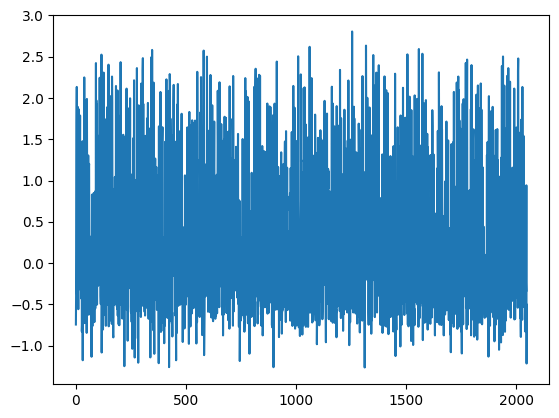

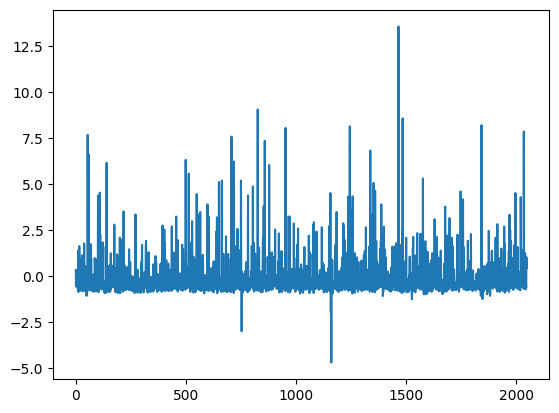

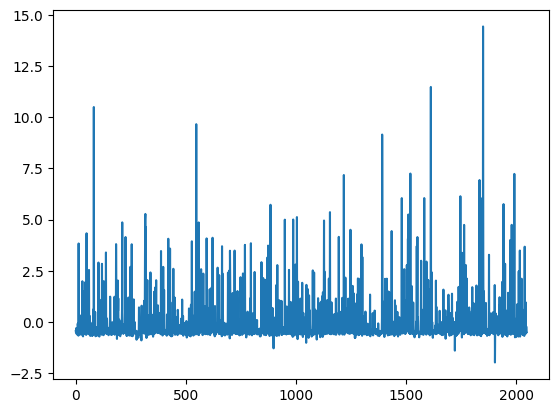

[1849 1612   82  547 1391 1519 1991 1217 1833 1746]


In [13]:
plt.figure(0).clf()
plt.plot(sp_features_ood[645])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()

plt.figure(0).clf()
plt.plot(cl_features_ood[645])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()

idx = 645
plt.figure(0).clf()
plt.plot(ssl_features_ood[idx])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()
print((-ssl_features_ood[idx]).argsort()[:10])

In [14]:
## calculate fpr, tpr, Threshold 

labels = [0] * len(fl_din) + [1] * len(fl_dout)
print("length of labels is:", len(labels))
data = np.concatenate((fl_din, fl_dout))
fpr, tpr, thresh = roc_curve(labels, data)
print(thresh.size)
thresh

length of labels is: 20000
4429


array([34378.4643488 , 34377.4643488 , 21758.4759835 , ...,
        1277.00238922,  1276.23334995,   404.26783389])

In [15]:
## select threshold that fpr approximates to 0.23
Th = thresh[4315]
print(Th)
index = np.where(sp_din > Th)[0]
print(index.size)
print(index.size/20000)

3651.079591766968
4588
0.2294


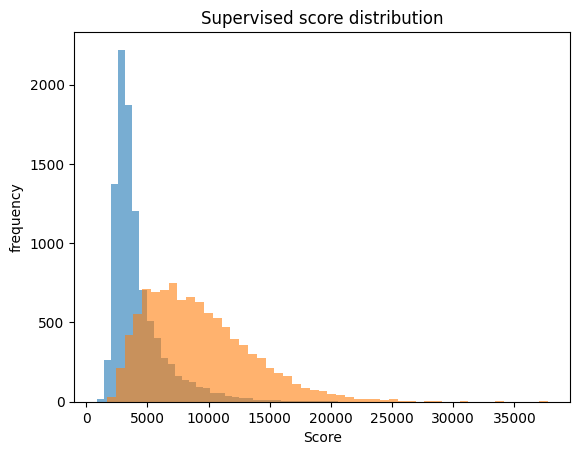

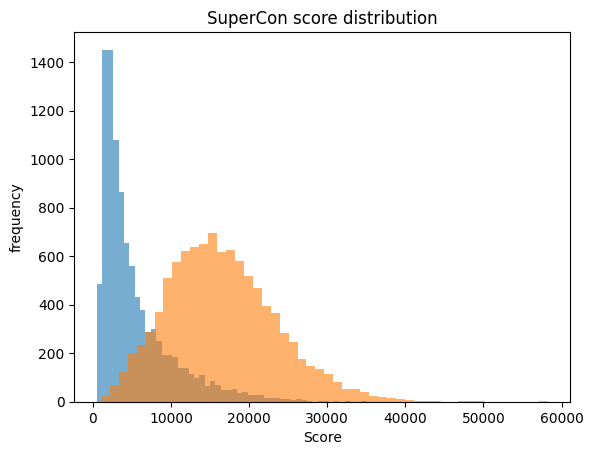

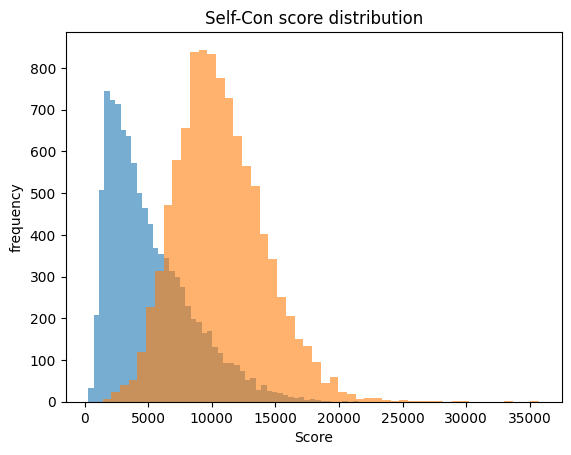

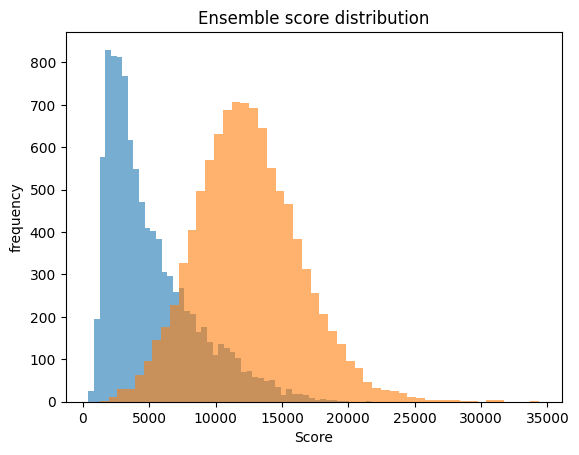

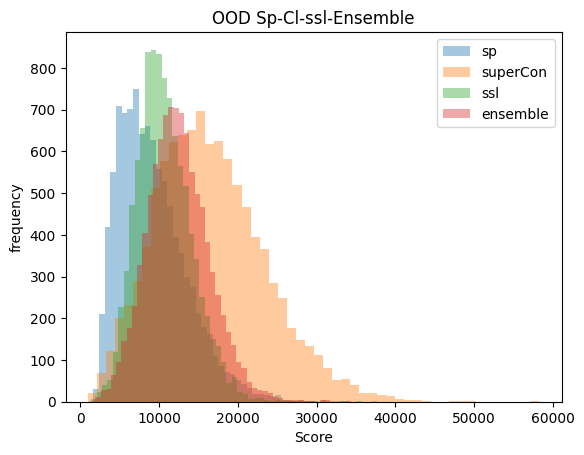

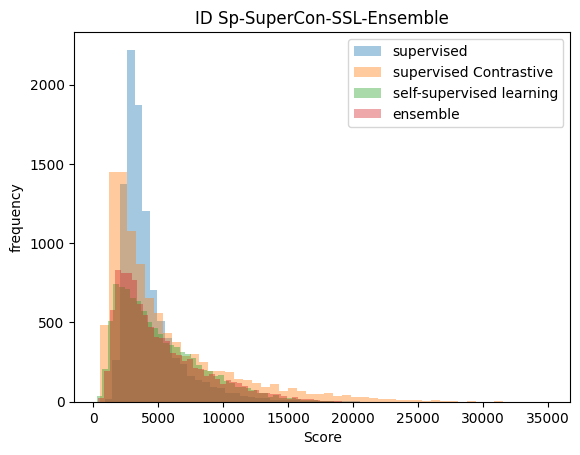

10000
10000


In [16]:
# score distritbuion of sl and ssl and ensemble
plt.title("Supervised score distribution")
plt.hist(sp_din, alpha=.6, bins=50, label= 'ID')  # density=False would make counts
plt.hist(sp_dout, alpha=.6, bins=50, label= 'ID')  # density=False would make counts
plt.ylabel('frequency')
plt.xlabel('Score');
plt.show()

plt.title("SuperCon score distribution")
plt.hist(cl_din, alpha=.6, bins=50, label= 'ID')  # density=False would make counts
plt.hist(cl_dout, alpha=.6, bins=50, label= 'ID')  # density=False would make counts
plt.ylabel('frequency')
plt.xlabel('Score');
plt.show()

plt.title("Self-Con score distribution")
plt.hist(ssl_din, alpha=.6, bins=50, label= 'ID')  # density=False would make counts
plt.hist(ssl_dout, alpha=.6, bins=50, label= 'ID')  # density=False would make counts
plt.ylabel('frequency')
plt.xlabel('Score');
plt.show()

plt.title("Ensemble score distribution")
plt.hist(fl_din, alpha=.6, bins=50, label= 'ID')  # density=False would make counts
plt.hist(fl_dout, alpha=.6, bins=50, label= 'ID')  # density=False would make counts
plt.ylabel('frequency')
plt.xlabel('Score');
plt.show()


# plt.hist(ssl_dout, alpha=.6, bins=50)  # density=False would make counts
# plt.hist(fl_dout, alpha=.6, bins=50)  # density=False would make counts
# plt.ylabel('frequency')
# plt.xlabel('Score');
# plt.show()



# plt.hist(ssl_din, alpha=.6, bins=50)  # density=False would make counts
# plt.hist(fl_din, alpha=.6, bins=50)  # density=False would make counts
# plt.ylabel('frequency')
# plt.xlabel('Score');
# plt.show()



plt.title("OOD Sp-Cl-ssl-Ensemble")
plt.hist(sp_dout, alpha=.4, bins=50, label='sp')  # density=False would make counts
plt.hist(cl_dout, alpha=.4, bins=50, label='superCon')
plt.hist(ssl_dout, alpha=.4, bins=50, label='ssl')
plt.hist(fl_dout, alpha=.4, bins=50, label='ensemble')# density=False would make counts
plt.legend()
plt.ylabel('frequency')
plt.xlabel('Score');
plt.show()



# plt.hist(sp_din, alpha=.6, bins=50)  # density=False would make counts
# plt.hist(fl_din, alpha=.6, bins=50)  # density=False would make counts
# plt.ylabel('frequency')
# plt.xlabel('Score');
# plt.show()



plt.title("ID Sp-SuperCon-SSL-Ensemble")
plt.hist(sp_din, alpha=.4, bins=50, label='supervised')  # density=False would make counts
plt.hist(cl_din, alpha=.4, bins=50, label='supervised Contrastive')
plt.hist(ssl_din, alpha=.4, bins=50, label='self-supervised learning')
plt.hist(fl_din, alpha=.4, bins=50, label='ensemble')# density=False would make counts
plt.legend()
plt.ylabel('frequency')
plt.xlabel('Score');
plt.show()


print(ssl_dout.size)
print(fl_dout.size)

In [17]:
# find a identical precision rate (TP/(TP+FP))
# find a identical fpr 
Th2 = thresh[3200]
print(Th2)
sp_fpr_idx = np.where(sp_din > Th)[0]
fl_fpr_idx = np.where(fl_din > Th2)[0]
print(sp_fpr_idx.size)
print(fl_fpr_idx.size)


sp_fnr_idx = np.where(sp_dout < Th)[0]
fl_fnr_idx = np.where(fl_dout < Th2)[0]
print(sp_fnr_idx.size)
print(fl_fnr_idx.size)
print(sp_fnr_idx[:150])
print(fl_fnr_idx[:150])

7342.997003284193
4588
2218
523
825
[  11   12   15   42   66   89   98  137  156  164  193  215  256  257
  277  278  280  292  333  353  383  416  432  438  446  456  458  463
  472  517  542  547  551  587  590  608  616  619  625  632  704  736
  764  766  803  804  805  810  816  817  842  875  883  890  895  908
  946  957  960 1056 1067 1092 1133 1149 1161 1202 1228 1242 1260 1271
 1300 1326 1327 1332 1347 1359 1363 1397 1405 1413 1427 1433 1435 1445
 1450 1458 1482 1489 1519 1554 1568 1572 1584 1586 1602 1626 1662 1695
 1705 1726 1730 1769 1778 1780 1787 1791 1822 1912 1927 1940 1952 1986
 1995 2025 2059 2090 2100 2102 2117 2160 2178 2203 2224 2266 2316 2320
 2324 2349 2352 2374 2376 2402 2411 2452 2480 2485 2486 2495 2513 2515
 2546 2561 2573 2583 2603 2621 2637 2639 2665 2698]
[  12   13   15   17   50   58   68   93   94  131  149  156  160  193
  203  209  214  233  234  255  259  278  279  298  331  338  351  353
  360  364  394  412  438  446  448  456  471  477  493  506

In [18]:
ood_labels = np.load("./supervised_cifar100/labels_ood.npy")

In [19]:
f_change= fl_dout - sp_dout
indices = (-f_change).argsort()[:10]
print(indices)

[4370 3735 3330 9454 6249 4137 1393 8437  829 4309]


In [20]:
## find sample index that change from TP to FN. 
idx_fn_to_tp1 = np.setdiff1d(fl_fnr_idx, sp_fnr_idx)
print(idx_fn_to_tp1.size)

622


320
[  11   42   66   89   98  137  164  215  256  257  277  280  292  333
  383  416  432  458  463  472  547  551  587  590  736  764  804  805
  810  816  842  875  883  895  908  946 1067 1161 1242 1260 1326 1363
 1405 1413 1445 1450 1458 1482 1489 1586 1602 1695 1726 1769 1780 1787
 1791 1912 1927 1986 1995 2102 2178 2266 2316 2324 2352 2374 2376 2402
 2411 2485 2495 2513 2515 2561 2573 2621 2637 2639 2698 2744 2779 2794
 2797 2855 2901 2983 3019 3061 3160 3197 3229 3236 3254 3259 3275 3288
 3330 3359 3392 3410 3430 3431 3471 3496 3500 3529 3549 3634 3658 3755
 3769 3792 3814 3847 3877 3882 3887 3888 3961 3964 3970 4030 4072 4090
 4095 4118 4138 4143 4145 4165 4185 4213 4218 4254 4266 4268 4296 4349
 4404 4414 4431 4468 4486 4610 4648 4692 4749 4751 4760 4775 4821 4828
 4915 4924 4959 4962 5006 5008 5015 5025 5052 5066 5080 5090 5115 5149
 5176 5206 5217 5219 5264 5278 5297 5307 5352 5361 5368 5467 5497 5540
 5550 5578 5596 5698 5700 5733 5785 5790 5886 5892 5953 6058 6099 6146
 6

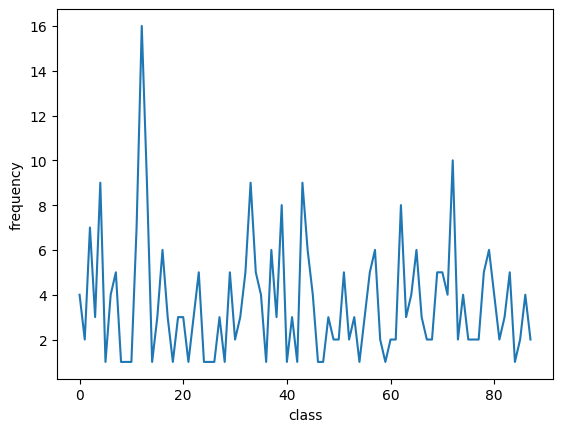

[5 0 5 5 6 6 9 0 6 6 6 0 9 5 5 9 4 9 7 2 5 6 5 5 6 6 6 6 2 2 6 6 2 5 6 2 0
 6 6 6 2 6 4 9 8 2 0 5 5 9 4 6 5 5 2 5 2]
[3 3 3 3 3 3 0 4 3 3 4 8 3 3 3 1 3 0 4 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3
 3 3 3 3 3 3 8 0 3 3 3 3 3 3 3 4 3 3 3 3]
(array([ 35,  41,  81, 112, 126, 168, 173, 224, 285, 290]),)


In [21]:
## get sample index that change from FN to TP
## get the corresponding label and closest cluster

idx_fn_to_tp = np.setdiff1d(sp_fnr_idx, fl_fnr_idx)
print(idx_fn_to_tp.size)
print(idx_fn_to_tp[:415])
# print(ood_labels[fn_to_tp[:415]])
label_fn_to_tp = ood_labels[idx_fn_to_tp[:415]]
print(label_fn_to_tp)
unique, counts = np.unique(label_fn_to_tp, return_counts=True)
print(np.asarray((unique, counts)).T)
# print(counts)
plt.plot(counts)
plt.ylabel('frequency')
plt.xlabel('class');
plt.show()


##  cluster 
sl_cluster_fn_to_tp = sp_idxood[idx_fn_to_tp]
fl_cluster_fn_to_tp = fl_idxood[idx_fn_to_tp]
# print(sl_cluster_fn_to_tp)
# print(fl_cluster_fn_to_tp)
d_index = np.where(sl_cluster_fn_to_tp != fl_cluster_fn_to_tp)
# print(d_index)
print(sl_cluster_fn_to_tp[d_index])
print(fl_cluster_fn_to_tp[d_index])

print(np.where(label_fn_to_tp == 81))

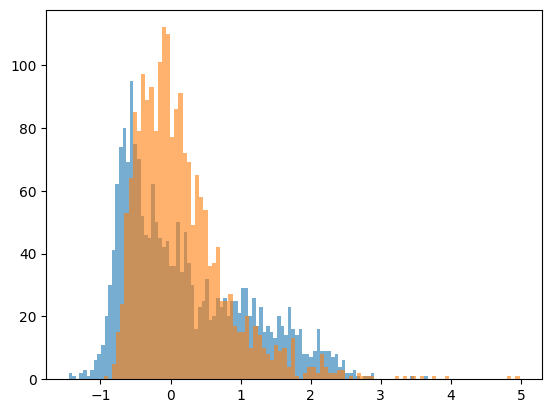

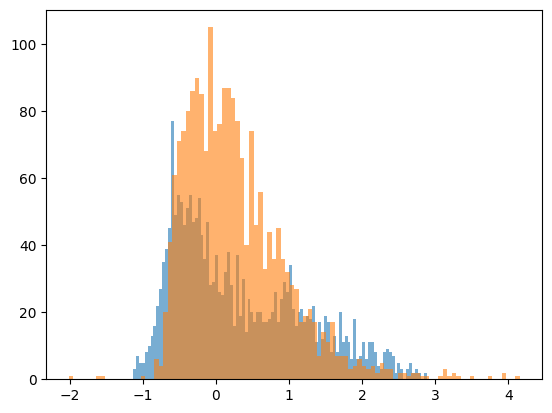

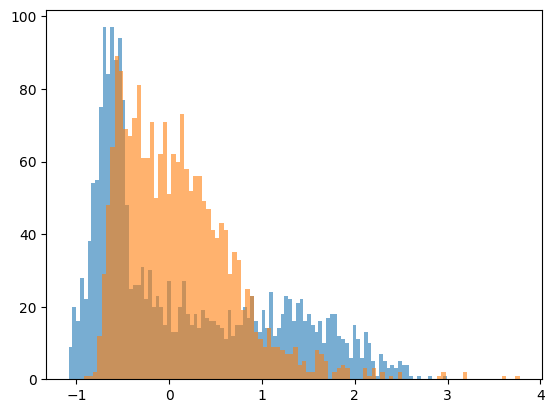

In [22]:
## visualize one fn -> tp sample feature


plt.figure(0).clf()
# plt.plot(0.9 * sp_features_ood[50])
plt.hist(0.9 * sp_features_ood[50], alpha=.6, bins=100)
plt.hist(fl_features_ood[60], alpha=.6, bins=100)
plt.show()

plt.figure(1).clf()
# plt.plot(0.9 * sp_features_ood[50])
plt.hist(0.9 * sp_features_ood[6], alpha=.6, bins=100)
plt.hist(fl_features_ood[6], alpha=.6, bins=100)
plt.show()

plt.figure(2).clf()
# plt.plot(0.9 * sp_features_ood[50])
plt.hist(0.9 * sp_features_ood[11], alpha=.6, bins=100)
plt.hist(fl_features_ood[11], alpha=.6, bins=100)
plt.show()
# plt.figure(1).clf()
# # plt.plot(0.1 * ssl_features_ood[50])
# plt.hist(0.1 * ssl_features_ood[50], bins=100)
# plt.show()


# plt.figure(2).clf()
# # plt.plot(0.1 * fl_features_ood[50])
# plt.hist(fl_features_ood[60], bins=100)
# plt.show()

6922


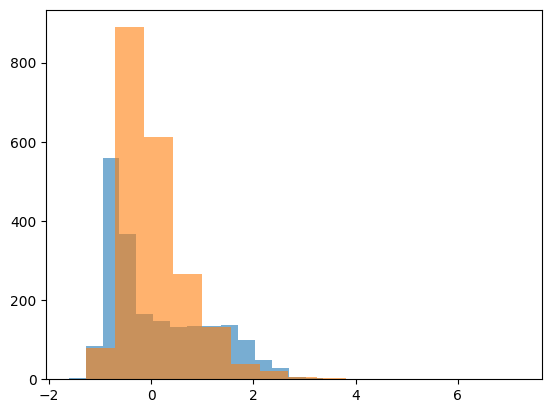

In [23]:
ix = idx_fn_to_tp[225]
print(ix)

# plt.figure(0).clf()
# plt.plot(0.9 * sp_features_ood[50])
plt.hist(0.9 * sp_features_ood[ix], alpha=.6, bins=15)
plt.hist(fl_features_ood[ix], alpha=.6, bins=15)
plt.show()

In [24]:
# ## get false negative index and number
# index2 = np.where(sp_dout < Th)[0]
# # print(index[:150])
# print(index2.size)
# # print(ood_labels[:150])

In [25]:
# ## get false negative index and number
# index2 = np.where(sp_dout < Th)[0]
# # print(index[:150])
# print(index2.size)
# # print(ood_labels[:150])

In [26]:
# index1 = np.where(fl_dout < Th)[0]
# # print(index1)
# index1.size

length of labels is: 20000
size of threshold is : [37734.50014503 37733.50014503 30545.55789858 ...  1689.0294869
  1687.31400305   875.61908116]
size of fpr is : [0.     0.     0.     ... 0.9955 0.9955 1.    ]
size of tpr is : [0.000e+00 1.000e-04 1.200e-03 ... 9.999e-01 1.000e+00 1.000e+00]


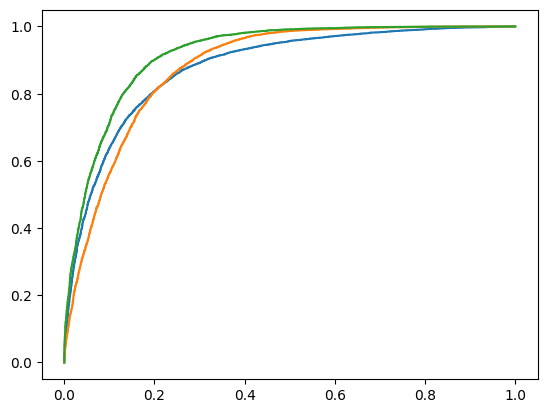

In [27]:
def get_roc_sklearn_plot1(xin1, xood1, xin2, xood2, xin3, xood3):
    
    labels1 = [0] * len(xin1) + [1] * len(xood1)
    print("length of labels is:", len(labels1))
    data1 = np.concatenate((xin1, xood1))
    labels2 = [0] * len(xin2) + [1] * len(xood2)
    data2 = np.concatenate((xin2, xood2))
    labels3 = [0] * len(xin3) + [1] * len(xood3)
    data3 = np.concatenate((xin3, xood3))
    
    plt.figure(0).clf()
    fpr, tpr, thresh = roc_curve(labels1, data1)
    print("size of threshold is :", thresh)
    plt.plot(fpr,tpr,label="SL")
    print("size of fpr is :", fpr)
    print("size of tpr is :", tpr)
    
    fpr, tpr, thresh = roc_curve(labels2, data2)
    plt.plot(fpr,tpr,label="SSL")
    
    
    fpr, tpr, thresh = roc_curve(labels3, data3)
    plt.plot(fpr,tpr,label="Ensemble")
    
get_roc_sklearn_plot1(sp_din, sp_dout, ssl_din, ssl_dout, fl_din, fl_dout)

In [28]:
# fn_to_tp = np.setdiff1d(index, index1)
# print(fn_to_tp[:150])
# print(ood_labels[fn_to_tp[:150]])
# print(ood_labels[50])

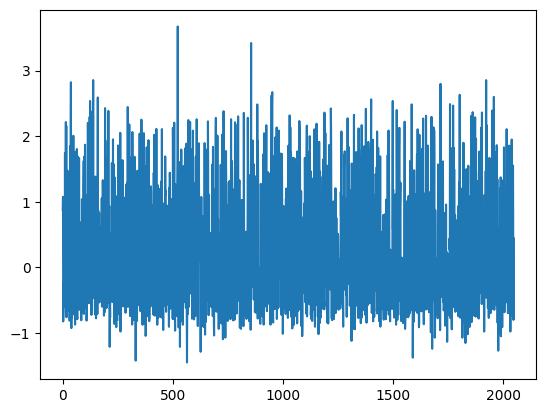

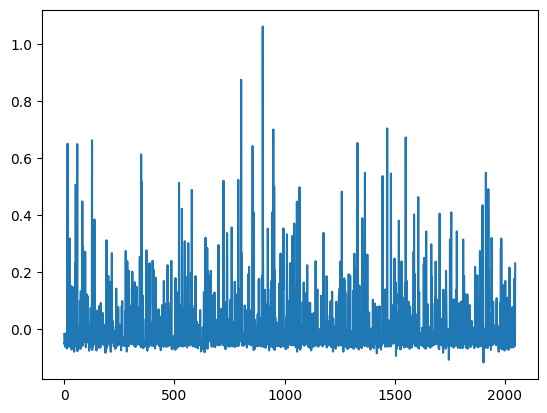

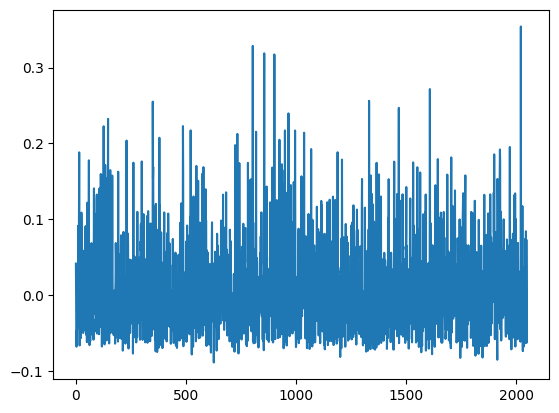

In [29]:
## visualize one fn -> tp sample feature

plt.figure(0).clf()
plt.plot(0.9 * sp_features_ood[50])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()

plt.figure(1).clf()
plt.plot(0.1 * ssl_features_ood[50])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()


plt.figure(1).clf()
plt.plot(0.1 * fl_features_ood[50])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()


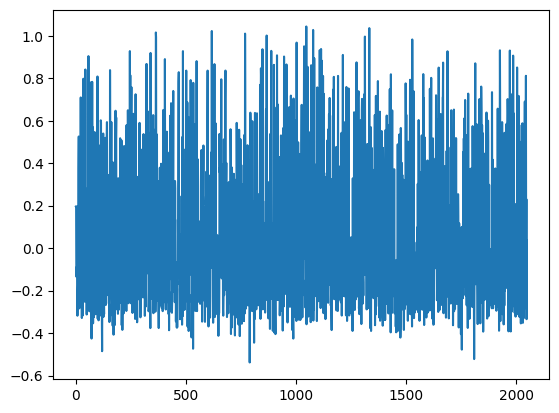

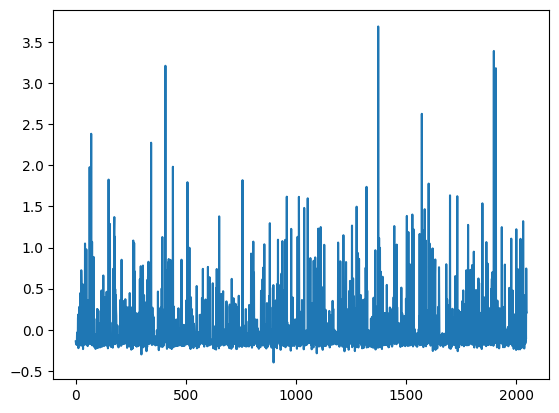

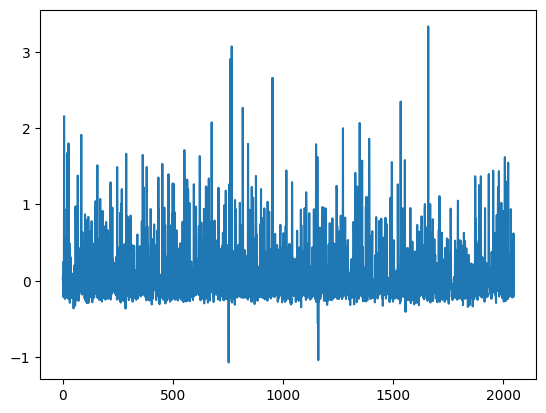

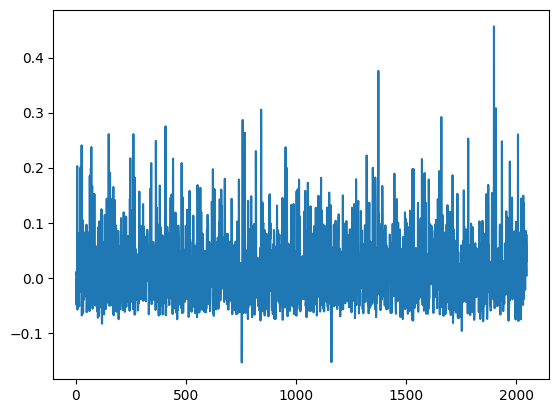

In [30]:
## visualize one fn -> tp sample feature

plt.figure(0).clf()
plt.plot(0.33 * sp_features_ood[257])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()

plt.figure(1).clf()
plt.plot(0.33 * ssl_features_ood[257])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()

plt.figure(2).clf()
plt.plot(0.34 * cl_features_ood[257])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()


plt.figure(3).clf()
plt.plot(0.1 * fl_features_ood[257])
#     plt.hist(ftrain[60], density=True, bins=100)
plt.show()

In [31]:
## find the largest values in ssl feature

ssl_idx = (-ssl_features_ood[6]).argsort()[:10]
ssl_idx

array([ 986,  709,  571, 1705, 1057, 1700,  540,  870, 1730, 1239])

In [32]:
sp_features_ood[6][986]

0.49846923

In [33]:
ssl_idx = (-ssl_features_ood[17]).argsort()[:10]
ssl_idx

array([ 563,  172, 1793,  575, 1314, 1283,  534, 1077, 2002,    6])

In [34]:
a = [1, 2, 3]
b = [1]